In [4]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image

import torchvision.transforms as T

from torchinfo import summary

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()
dev = "cuda"

In [5]:
from lovely_tensors import monkey_patch
monkey_patch()

In [6]:
def sigmas(x: torch.Tensor, n=3):
    u = x / (x.std()*n*2) # *2 because I want +/- n sigmas
    return u - u.mean() + 0.5

In [10]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae.requires_grad_(False).to(dev)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder.requires_grad_(False).to(dev)

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet.requires_grad_(False).to(dev)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


In [7]:
img = T.ToTensor()(Image.open('macaw.jpg').resize((512, 512))).to(dev)
img

tensor[3, 512, 512] n=786432 x∈[0., 1.000] μ=0.451 σ=0.254 cuda:0

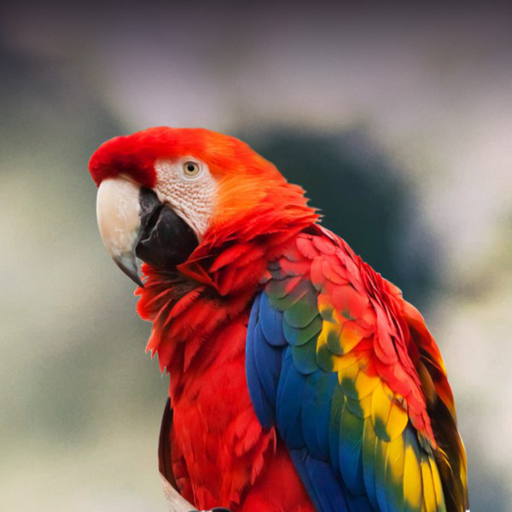

In [8]:
img.rgb

In [11]:
latent = vae.encode(img[None]*2-1).latent_dist.sample()
latent

tensor[1, 4, 64, 64] n=16384 x∈[-49.145, 36.673] μ=0.482 σ=5.105 cuda:0

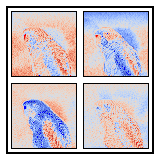

In [47]:
sigmas(latent).chans

In [15]:
decoded_image = (vae.decode(latent).sample/2+0.5).clip(0,1)
decoded_image 

tensor[1, 3, 512, 512] n=786432 x∈[0., 1.000] μ=0.445 σ=0.253 cuda:0

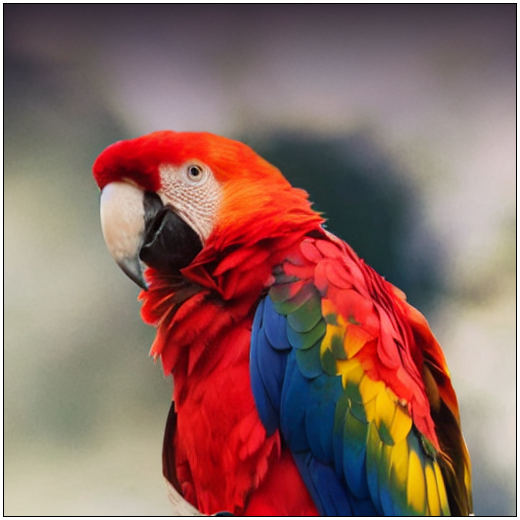

In [16]:
decoded_image.rgb

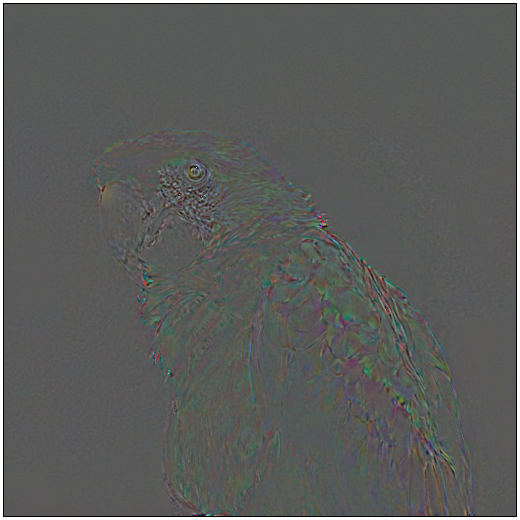

In [17]:
diff = (img - decoded_image)
diff += diff.min()
diff.rgb

In [18]:
def vae_encode_img(x):
    return vae.encode(x[None]*2-1).latent_dist.sample()*0.18215

def vae_decode_img(x):
    return (vae.decode(x/0.18215).sample/2+0.5).clip(0,1)

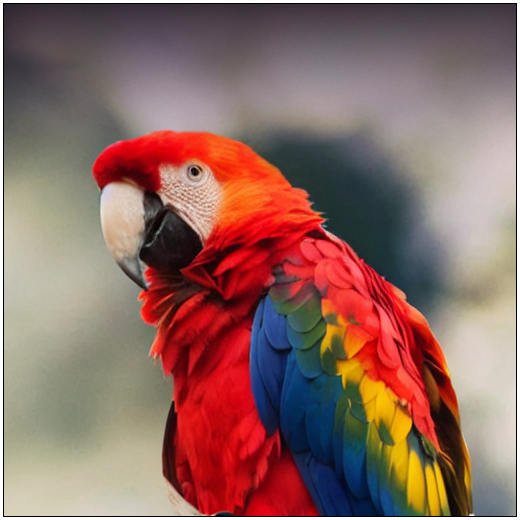

In [19]:
vae_decode_img(vae_encode_img(img)).rgb

In [20]:
p1 = "My cute cat"
p2 = "My cute dog"
p3 = "A photo of pasta on a plate"

In [21]:
tokenizer(p1, return_tensors="pt").input_ids.p

tensor([[49406,   607,  2242,  2368, 49407]])

In [22]:
tokenizer(p2, return_tensors="pt").input_ids.p

tensor([[49406,   607,  2242,  1929, 49407]])

In [23]:
tokenizer(p3, return_tensors="pt").input_ids.p

tensor([[49406,   320,  1125,   539, 10441,   525,   320,  5135, 49407]])

In [24]:
tokens = tokenizer([p3, ""],
                         padding="max_length",
                         max_length=77,
                         return_tensors="pt").input_ids.to(dev)
tokens.v

tensor[2, 77] n=154 x∈[320.000, 4.941e+04] μ=4.728e+04 σ=9.805e+03 i64 cuda:0
tensor([[49406,   320,  1125,   539, 10441,   525,   320,  5135, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 4

In [25]:
embeddings = text_encoder(tokens).last_hidden_state
embeddings

tensor[2, 77, 768] n=118272 x∈[-28.091, 33.063] μ=-0.111 σ=1.031 cuda:0

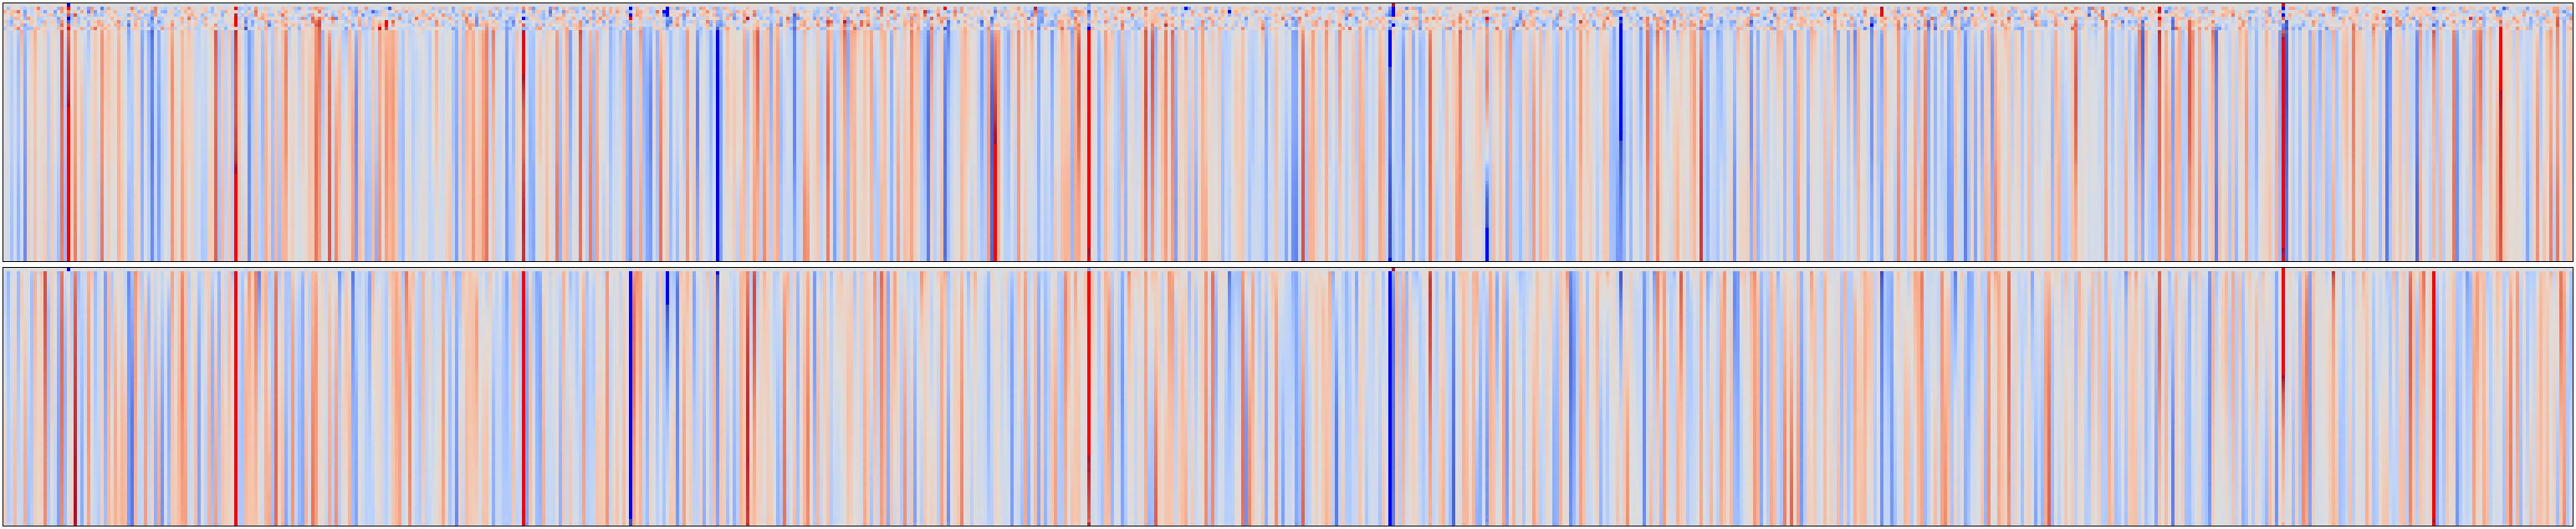

In [26]:
sigmas(embeddings).chans(scale=4)

In [27]:
generator = torch.manual_seed(32)
scheduler.set_timesteps(50)

In [28]:
ln = torch.randn((1, 4, 64, 64), generator=generator).to(dev)
ln *= scheduler.init_noise_sigma
ln 

tensor[1, 4, 64, 64] n=16384 x∈[-57.533, 59.995] μ=-0.025 σ=14.616 cuda:0

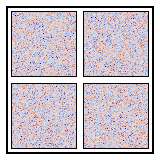

In [29]:
sigmas(ln).chans

In [30]:
ln

tensor[1, 4, 64, 64] n=16384 x∈[-57.533, 59.995] μ=-0.025 σ=14.616 cuda:0

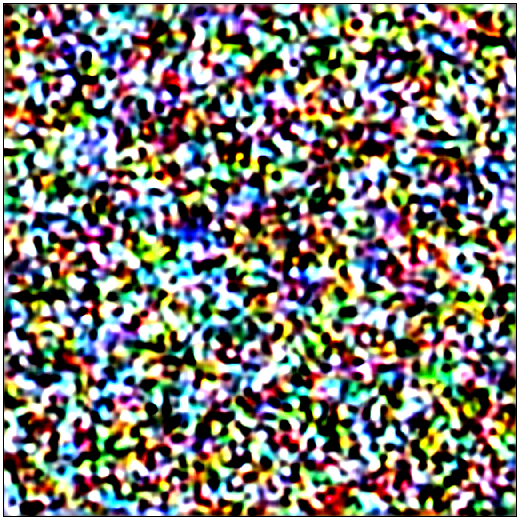

In [31]:
vae_decode_img(ln).rgb

In [32]:
scheduler.timesteps.v

tensor[50] x∈[0., 999.000] μ=499.500 σ=297.200 f64
tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8980, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4082, 632.0204, 611.6327, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8776, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000], dtype=torch.float64)

In [33]:
t = scheduler.timesteps[0]

scaled_ln = scheduler.scale_model_input(torch.cat([ln]*2), t)

In [34]:
preds = unet(scaled_ln, t, encoder_hidden_states=embeddings).sample

In [35]:
preds

tensor[2, 4, 64, 64] n=32768 x∈[-3.957, 4.115] μ=-0.003 σ=0.997 cuda:0

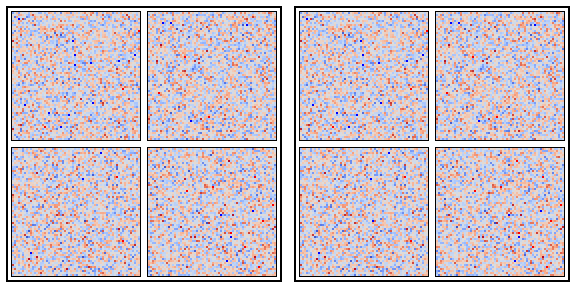

In [36]:
sigmas(preds).chans(scale=2)

In [37]:
P, U = preds.chunk(2)
noise_pred = U + 8 * (P - U)

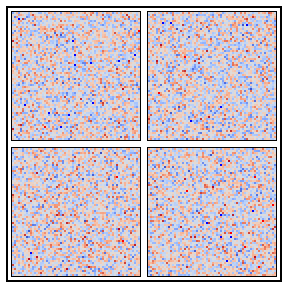

In [38]:
sigmas(noise_pred).chans(scale=2)

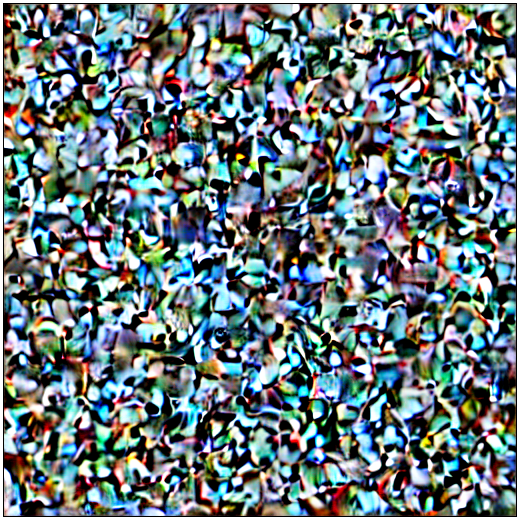

In [39]:
vae_decode_img(noise_pred).rgb

In [40]:
ln = scheduler.step(noise_pred, t, ln).prev_sample

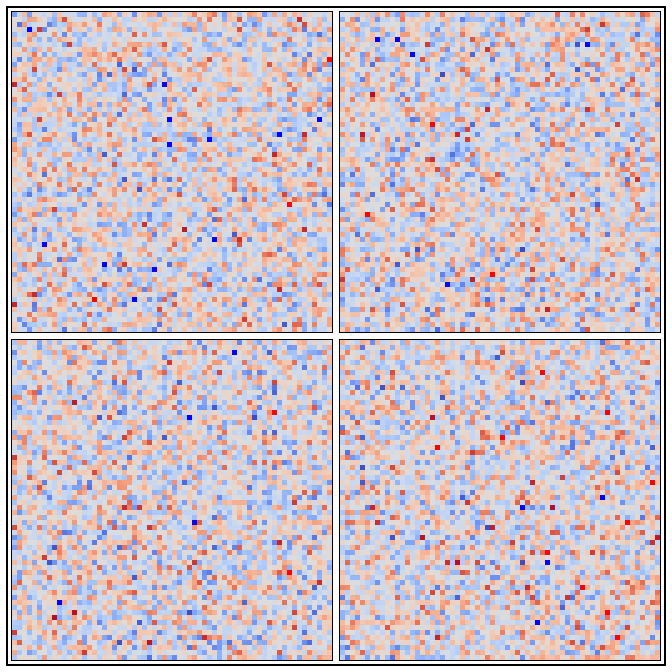

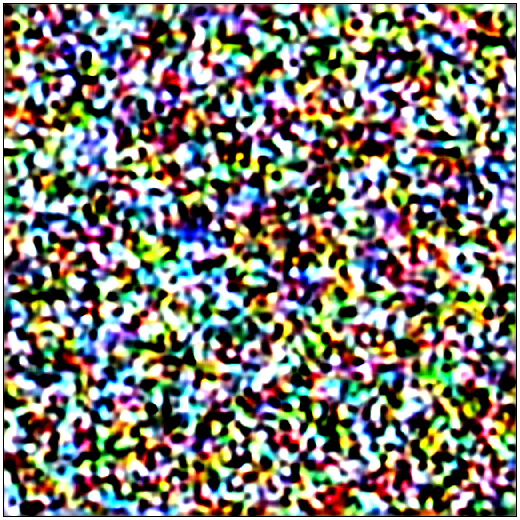

In [41]:
display(sigmas(ln).chans(scale=5))
display(vae_decode_img(ln).rgb)

In [42]:
ln = torch.randn((1, 4, 64, 64), generator=generator).to(dev)
ln *= scheduler.init_noise_sigma
ln

tensor[1, 4, 64, 64] n=16384 x∈[-64.910, 58.637] μ=-0.042 σ=14.690 cuda:0

In [43]:
saved_imgs = []

for i, t in tqdm(enumerate(scheduler.timesteps)):
    scaled_ln = scheduler.scale_model_input(torch.cat([ln]*2), t)
    
    preds = unet(scaled_ln, t, encoder_hidden_states=embeddings).sample
    
    P, U = preds.chunk(2)
    noise_pred = U + 8 * (P - U)
    
    
    ln = scheduler.step(noise_pred, t, ln).prev_sample
    saved_imgs.append(torch.cat([vae_decode_img(noise_pred), vae_decode_img(ln)], axis=-1).rgb)

0it [00:00, ?it/s]

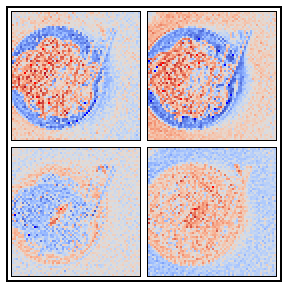

In [46]:
sigmas(ln).chans(scale=2)

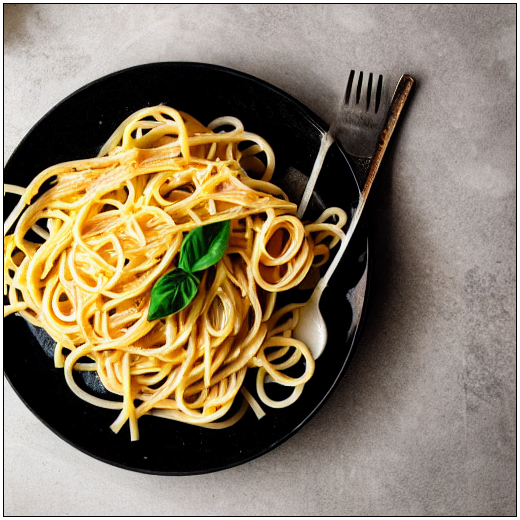

In [45]:
vae_decode_img(ln).rgb